# Early testing pipeline

The purpose of this pipeline is to test different features compared to a baseline. <br>
<br>
The baseline are the features given for the first phase. The different extract_features are written in different .py files that are here imported. <br>
The different features tested already are:
- Drop z-coordinates and only use xy-coordinates.
- Look at movement vectors between different frames.
- Frames averaging.
- Transforming coordinates to polar.
- Separate frames in different ROI (regions are different body parts).
- Layered average.

# Evaluation of features

The baseline feature set achieves the following scores (2 frames average): <br>
- train accuracy: 86%<br>
- cross-validation accuracy: 66%<br>

## 1. Loading data

In [1]:
import sklearn
import numpy as np
import csv
import pickle
import time
import os

%matplotlib notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedGroupKFold

import utils_for_students

In [2]:
train_samples = []
test_samples = []

train_samples = utils_for_students.load_dataset_stage2('data/stage2_labels_train.csv', 'train')
test_samples = utils_for_students.load_dataset_stage2('data/stage2_ids_test.csv', 'test')

### Change only the following cell!!!

In [3]:
#Change the file from which you import for testing different feature extraction

#from baseline import extract_features
#from layered_avg import extract_features
#from vectors import extract_features
from frame_avg import extract_features

In [4]:
# Concatenate the training set features.
X_train = []
y_train = []
signers_train = []
for sample in train_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/train/', sample['path']))
    #we will still need a workaround for this.
    X_train.append(extract_features(pose_sequence))
    y_train.append(sample['label'])
    signers_train.append(sample['signer'])
    
# Concatenate the test set features.
X_test = []
test_ids = []
for sample in test_samples:
    pose_sequence = utils_for_students.load_sample_stage2(os.path.join('data/stage2/test/', sample['path']))
    X_test.append(extract_features(pose_sequence))
    test_ids.append(sample['id'])

#Combining to numpy array
X_train = np.stack(X_train)
X_test = np.stack(X_test)

# Encode the labels as integers
label_encoder = utils_for_students.label_encoder()
y_train = label_encoder.transform(y_train)

## 2. Feature extraction

In [5]:
print(X_train.shape)
print(X_test.shape)

(2191, 750)
(541, 750)


## 3. Pipeline

In [34]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.feature_selection import SelectFwe, SelectFromModel, SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.decomposition import PCA

#chosen PCA instead of LDA as the n_components of LDA has to be <= min(n_classes - 1, n_features) which is 14 in
#this case (down from 750). Which is likely to little given the that the features are only x, y or z values.
preprocessing = Pipeline([
    ('normalizer', Normalizer()),
    ('scaler', StandardScaler()),
    ('decompose', PCA()),
    ('rescale', StandardScaler()),
                        ]) 

#TODO: define feature selection pipeline here
#first we remove the features that mithingsght lead to false results
#then we use selectFromModel to assign weights and take the least important features away for generalization
#ofcourse only using linear regression models (the same model as the actual classifier)
feature_selection = Pipeline([
    #('selectFromModel', SelectFromModel(RidgeClassifier(fit_intercept=False))),
    ('selectKBest', SelectKBest()),
                            ]) 

In [35]:
classifier = RidgeClassifier(fit_intercept=False)

In [36]:
#param grid has been set to some constants because this is not subject of optimization in this notebook
param_grid = {
    #'feature_selection__selectFWE__score_func': [chi2, f_classif, mutual_info_classif],
    #'feature_selection__selectFWE__alpha': [0.15],#[1e-2, 2.5e-2, 5e-2, 1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1, 6e-1, 6.5e-1, 7e-1, 9e-1, 9.9e-1, 1],
    #'feature_selection__selectFromModel__threshold': ["1.2*mean"],#["0.25*mean", "0.75*mean", "1*mean", "1.2*mean", "1.25*mean", "1.5*mean", "0.5*median", "0.75*median", "1*median", "1.25*median", "2*median", "2.05*median", "2.1*median", "2.2*median"],
    #'preprocessing__decompose__n_components': ['mle'],#['mle', 140, 150, 160, 170, 180, 190, 200, 300, 400, 500, 600, 700],
    'feature_selection__selectKBest__score_func': [f_classif],# mutual_info_classif],
    'feature_selection__selectKBest__k': [140],#[50,60,70,80,90,100,105,110,115, 120, 140, 145, 150, 155, 160, 180, 200,220,240,260,280,550,600,610,620,630],
    'classifier__alpha': [1],#[1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1],
    #'classifier__C': [1.0e-6, 1.0e-5, 1.0e-4, 1.0e-3, 1.0e-2, 1.0e-1, 1.0],
    'classifier__tol': [1.0e-5],#[1.0e-5, 1.0e-4,  1.0e-2, 1.0e-1, 0.2, 0.5, 0.7, 0.9],
    'classifier__class_weight': ['balanced'],#['balanced', None]
 }

In [37]:
n_folds = 4

# The function below is just an example!
#TODO: write a better split function here?
#split according to signer for i.i.d. sets
def create_folds(X,y,n_folds):
    folds = []
    cv_object = StratifiedGroupKFold(n_splits = n_folds)
    for (train_indices, val_indices) in  cv_object.split(X_train, y_train, groups=signers_train):
        folds.append((train_indices,val_indices))
    return folds

## 4. Training model

In [38]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

folds = create_folds(X_train,y_train,n_folds)
assert isinstance(folds,list),'Folds must be presented as tuples of train and test index lists' 

# train model
cv = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=folds, verbose=1, return_train_score=True, refit=True)
cv.fit(X_train, y_train)
    
prediction = utils_for_students.label_encoder().inverse_transform(cv.best_estimator_.predict(X_test))

Fitting 4 folds for each of 1 candidates, totalling 4 fits


## 5. Printing scores

In [39]:
results = cv.cv_results_
mean_train_score = results['mean_train_score'][cv.best_index_]
std_train_score = results['std_train_score'][cv.best_index_]
mean_cv_score = results['mean_test_score'][cv.best_index_]
std_cv_score = results['std_test_score'][cv.best_index_]

print('Training accuracy {} +/- {}'.format(mean_train_score, std_train_score))
print('Cross-validation accuracy: {} +/- {}'.format(mean_cv_score, std_cv_score))

print('Best estimator:')
print(cv.best_estimator_)

Training accuracy 0.8645455423769717 +/- 0.00909630546357861
Cross-validation accuracy: 0.66297882969668 +/- 0.0535272729073556
Best estimator:
Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('normalizer', Normalizer()),
                                 ('scaler', StandardScaler()),
                                 ('decompose', PCA()),
                                 ('rescale', StandardScaler())])),
                ('feature_selection',
                 Pipeline(steps=[('selectKBest', SelectKBest(k=140))])),
                ('classifier',
                 RidgeClassifier(alpha=1, class_weight='balanced',
                                 fit_intercept=False, tol=1e-05))])


In [30]:
print(cv.best_estimator_.named_steps['classifier'].n_features_in_)

AttributeError: 'GridSearchCV' object has no attribute 'best_estimator_'

Best parameters set found on development set:  {'classifier__alpha': 1, 'classifier__class_weight': None, 'classifier__tol': 1e-05, 'feature_selection__selectFromModel__threshold': '1.2*mean'}
Grid scores on training data set:



<IPython.core.display.Javascript object>


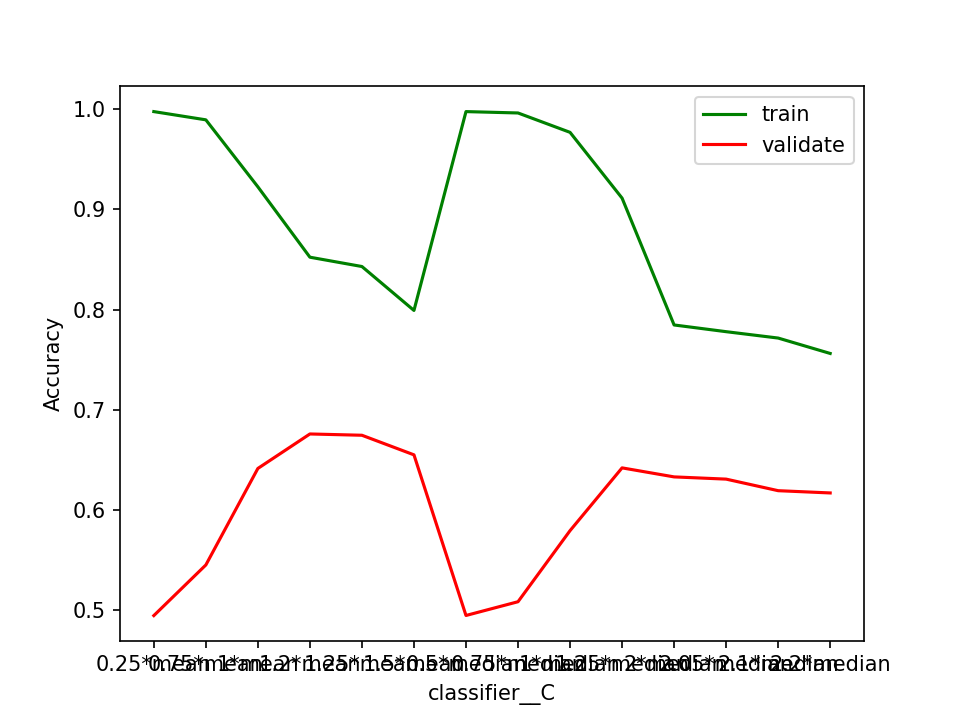

In [289]:
# use for visualizing certain evolutions

import matplotlib.pyplot as plt

print("Best parameters set found on development set: ",cv.best_params_)
# store the best optimization parameter for later reuse
bestC2 = cv.best_params_['classifier__alpha']

print("Grid scores on training data set:")
print()
cv_means = cv.cv_results_['mean_test_score']
cv_stds = cv.cv_results_['std_test_score']

train_means = cv.cv_results_['mean_train_score']
train_stds = cv.cv_results_['std_train_score']

#C_range = [0.92, 0.9, 0.8, 0.75, 0.5, 0.2, 1e-1, 5e-2, 2.5e-2]
C_range = ["0.25*mean", "0.75*mean", "1*mean", "1.2*mean", "1.25*mean", "1.5*mean", "0.5*median", "0.75*median", "1*median", "1.25*median", "2*median", "2.05*median", "2.1*median", "2.2*median"]
#C_range = [50,60,70,80,90,100,105,110,115, 120, 140, 145, 150, 155, 160, 180, 200,220,240,260,280,550,600,610,620,630]
#C_range = [True, False]
#C_range = ['mle', 140, 150, 160, 170, 180, 190, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750]
#C_range = [1.0e10, 1.0e9, 1.0e8, 1.0e7, 1.0e6, 1.0e5, 1.0e4, 1.0e3, 1.0e2, 10, 1.0]
#C_range = [1.0e-5, 1.0e-4,  1.0e-2, 1.0e-1, 0.2, 0.5, 0.7, 0.9]
# C_range = [1.0e-6, 1.0e-4, 1.0e-2, 1.0e-1, 0.2, 0.5, 0.8]
#C_range = [1e9, 1e8, 1e7, 1e6, 1e5, 1e4, 1e3, 1e2, 1]
#C_range = [1e-2, 2.5e-2, 5e-2, 1e-1, 1.5e-1, 2e-1, 3e-1, 5e-1, 6e-1, 6.5e-1, 7e-1, 9e-1, 9.9e-1, 1]
#C_range = ["f_classif", "chi2"]
plt.figure()
plt.plot(C_range,train_means,'g-',label="train")
plt.plot(C_range,cv_means,'r-',label="validate")
#plt.plot(np.log10(C_range),train_means,'g-',label="train")
#plt.plot(np.log10(C_range),cv_means,'r-',label="validate")
plt.xlabel("classifier__C")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 6. Make submission

In [252]:
# your data, used to name the output file
group = 15

# change this if you would like your submission outputfile to have a more detailed name, e.g. submission_with_special_preprocessing 
submission_prefix='submission'

# whether or not you want your created models and submissions versioned using timestamps
# (setting this to False will overwrite previously exported model and submission files of the same name)
use_timestamps = True

In [253]:
submission_dirname = 'submission'
if use_timestamps:
    timestamp = time.strftime("%Y%m%d-%H%M%S", time.localtime())
    filename_model = os.path.join(submission_dirname,f'stage2_model_Group{group}_{timestamp}.pkl')
    filename_submission =  os.path.join(submission_dirname,f'stage2_Group{group}_{timestamp}.csv')
else:
    filename_model = os.path.join(submission_dirname,f'stage2_model_Group{group}.pkl')
    filename_submission =  os.path.join(submission_dirname,f'stage2_Group{group}.csv')

if not os.path.exists(submission_dirname):
    os.mkdir(submission_dirname)    

with open(filename_model,'wb') as file:
    pickle.dump(cv,file)
    
prediction = label_encoder.inverse_transform(cv.best_estimator_.predict(X_test))
utils_for_students.create_submission_file(filename_submission, test_ids, prediction)